# Building a single neuron
To understand AI better, we will start out by looking at one of the lowest level in deep learning, the Neuron. 
we will look at:
<ol>
<li> Constituents of a neuron: parameters, activation
<li> Behavior of a neuron: loss and optimization
</ol>

## Constituents
A neuron is, at its core, a linear weighting of some inputs wrapped by some (non-linear) function called "activation function". A very simplistic implementation of a Neuron could look like this: 


In [1]:
# @ Author: Jakob Abou Zeid
# @ email: jakob.abouzeid@gmail.com
import typing
from collections.abc import Callable
import numpy as np

class Singleton:
    """This single neuron is not able to be part of a neural net, it only illustrates the functioning of a singleton. 
    To use, call with some activation function and give it an 1d-array of initial parameters."""
    def __init__(self, activation: Callable, parameters: np.array) -> None:
        self.activation = activation
        self.parameters = parameters

    def give_output(self: 'Neuron') -> float:
        if self.out_value is None:
            self.activate()
        return self.out_value

    def activate(self, inputs):
        z = inputs.dot(self.parameters)
        self.out_value = self.activation(z)
        return (self.out_value)

This single Neuron ("Singleton") will take a 2d-array of inputs, multiply them with the parameters and sum them up. Then it applies the activation-function and returns the value. Let's try this with a small matrix of integers, parameters set so the inputs are just added and a simple activation function that we can calculate in our heads: 

In [2]:
def act(x):
    """We use x³ as an example"""
    return x**3

in_matrix = np.random.randint(0,6,(4,3))

S = Singleton(act, np.array([1,1,1]).reshape(-1,1))
display(in_matrix)
S.activate(in_matrix)

array([[3, 1, 5],
       [3, 2, 2],
       [0, 1, 1],
       [5, 1, 3]])

array([[729],
       [343],
       [  8],
       [729]], dtype=int32)

Great! This works and we have all the constituents. Let's turn to behavior:


## Behavior of a neuron
Just summing up and squaring some numbers doesn't do a lot for us, yet, but one of the core ideas here is to tweak the parameters of the neuron such that it can 'learn' some function. To do that, we need to measure how well we are doing so far and in which direction we should tweak to improve. This measure is called **"loss" function** because it measures the divergence between the answers the neuron provides and the true answers. Improvement means making the loss smaller. 

To keep things simple, we will use the averaged squared error as our loss-function. So our singleton has the task of tweaking the parameters in such a way that the average squared error becomes smaller meaning if the activation function was f(x) = x, then we would perform an OLS regression. 

Then we figure out in which direction the parameters need to be tweaked so that the average squared error declines: 

$$ \frac{d \ MSE}{w_i} = Mean_j(\frac{d (\hat{y}_j- y_i)^2}{d w_j}), \frac{d (\hat{y}_j- y_i)^2}{d w_j} = 2 (\hat{y}_j- y_i) \frac{d \hat{y}_j}{d w_j}, \frac{d \hat{y}_j}{d w_j} = 2 * x_j$$

This method of using the derivative to iteratively tweak the parameters is called '**gradient descent**' and is the template for many other more advanced **optimizers**, like 'Adam'.

Let's start by creating a function for our neuron to learn: $f(x) = (3.14 x + 5.4)^3$

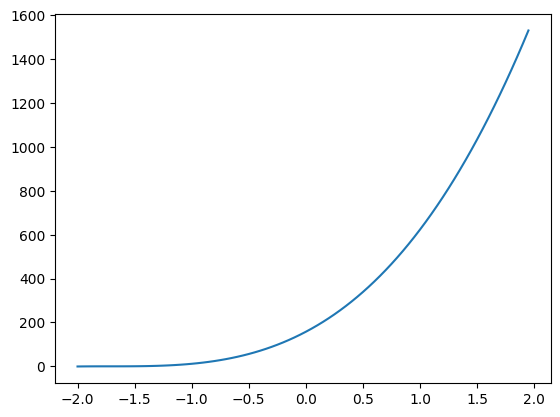

In [3]:
x_val = np.arange(-2, 2, .05)
par1, par2 = 3.14, 5.4
y_val = (par1* x_val + par2)**3

import matplotlib.pyplot as plt 
plt.plot(x_val, y_val)

And write a small function giving us the gradient of the loss function.

In [4]:
def grads(x, y_hat, y):
    grads = 2 * x * 2 * (y_hat - y)
    return grads.sum(axis = 0) / x.shape[0] #It should be the average gradient such that learning is independent of the number of observations we optimize on.

# let's test it real quick:
x = np.arange(-1,1,.05).reshape(-1,1)
x = np.hstack([x, np.ones(x.shape)])
y = (x.dot([[3.14], [5.4]]))**2
S = Singleton(act, [0,8])
y_hat = S.activate(x).reshape(-1,1)
grads(x, y_hat, y)

array([ -92.57056 , 1921.588634])

This means, if we estimate a constant 8, then the error  declines if we increase our first and decrease our second parameter. This is correct, since the true parameters are 3.14 and 5.4

MovieWriter ffmpeg unavailable; using Pillow instead.


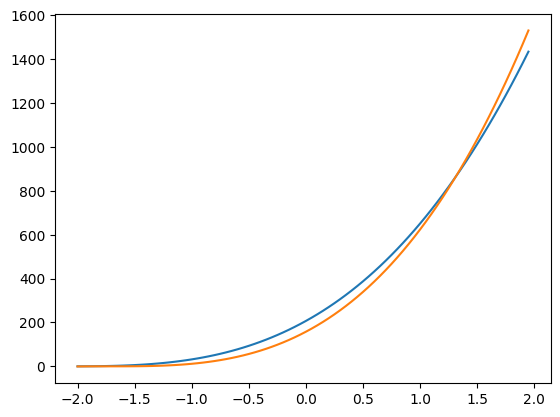

In [5]:
import matplotlib.animation as plt_ani

def train(neuron:Singleton, x, y, learning_rate = .0001, iterations = 1000):
    adj_tape =[]
    for i in range(iterations):
        y_hat = neuron.activate(x).reshape(-1,1)
        adjustments = -grads(x, y_hat, y) * learning_rate
        adj_tape.append(adjustments)
        neuron.parameters[0] += adjustments[0]
        neuron.parameters[1] += adjustments[1]
    return adj_tape

def animate(frame, fargs):
    print("recording frame ", frame, "\t\t\t", end="\r")
    neuron, x, y, learning_rate , iterations = fargs
    adj_tape.extend(train(*fargs))
    y_hat =neuron.activate(x)
    line.set_ydata(y_hat)
    return line


S = Singleton(act, np.array([0.,5.]).reshape(-1,1))
x_val_for_train = np.hstack([x_val.reshape(-1,1),np.ones((x_val.shape[0], 1))])

fig, ax = plt.subplots()
line, = ax.plot(x_val, S.activate(x_val_for_train))
plt.plot(x_val, y_val)
adj_tape = []
ani = plt_ani.FuncAnimation(fig, animate, frames=100, interval=100, fargs= ((S, x_val_for_train, y_val.reshape(-1,1), .00006, 1),))
ani.save("cubic_optimization.gif")

The concept is quite general already, we can also have our neuron learn things that aren't perfect functions but rather summary statistics:

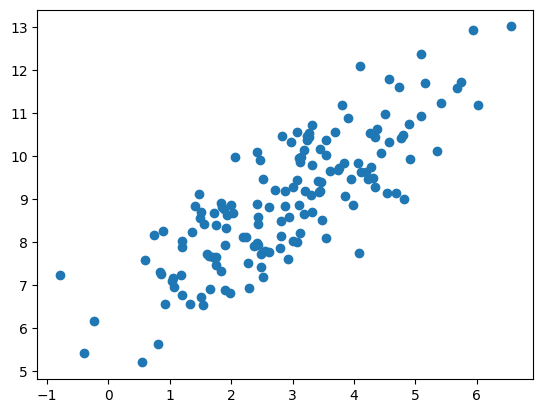

In [6]:
var_x, var_y = 1.6, 2
correlation = .8

cov = correlation * var_y**.5 * var_x**.5
data = np.random.multivariate_normal([3, 9], [[var_x,cov], [cov,var_y] ], (150, ))
x,y = data[:, 0], data[:,1]
plt.scatter(x,y)

MovieWriter ffmpeg unavailable; using Pillow instead.


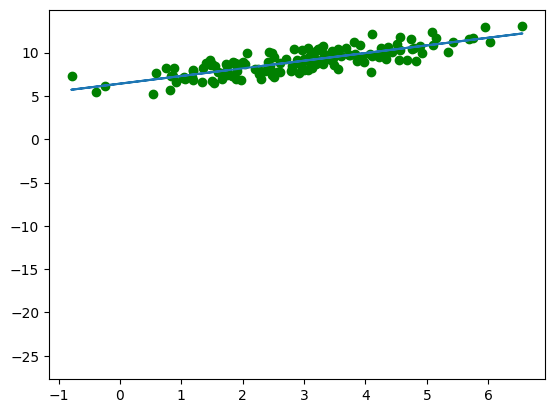

In [7]:
S = Singleton(lambda x: x, np.array([-5.,7.]).reshape(-1,1))
x_val_for_train = np.hstack([x.reshape(-1,1),np.ones((x.shape[0], 1))])

fig, ax = plt.subplots()
line, = ax.plot(x, S.activate(x_val_for_train))
plt.scatter(x, y, c='green')
adj_tape = []
ani = plt_ani.FuncAnimation(fig, animate, frames=500, interval=100, fargs= ((S, x_val_for_train, y.reshape(-1,1), .04, 1),))
ani.save("linear regression.gif")

This works great but what you don't see in this Jupyter notebook: I had to try a whole bunch of different learning rates to make it work. Some learning rates were just way to slow (I won't bore us with an example of that), the curve adjusted its height well but then took forever to adjust its slope, others were too fast, the curve somewhat approaches the best position but the learning rate was too large and the curve keeps jumping around. 

MovieWriter ffmpeg unavailable; using Pillow instead.


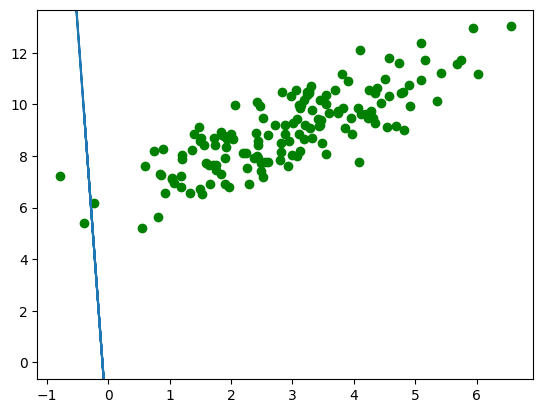

In [9]:
# too fast learning
learn_rate= .045


S = Singleton(lambda x: x, np.array([0.,0.]).reshape(-1,1))
x_val_for_train = np.hstack([x.reshape(-1,1),np.ones((x.shape[0], 1))])

fig, ax = plt.subplots()
plt.scatter(x, y, c='green')
line, = ax.plot(x, S.activate(x_val_for_train))
adj_tape = []
ani = plt_ani.FuncAnimation(fig, animate, frames=150, interval=150, fargs= ((S, x_val_for_train, y.reshape(-1,1), learn_rate, 1),))
ani.save("linear_too_fast.gif")

# Summary

We implemented a singleton (a neuron that cannot easily be connected to any other neurons, so it stays single forever) and wrote a training-function that uses the optimizer gradient decent and the loss function sum (actually mean) of squared errors to learn either a functional relation or a mere correlation.

In the next project, we will try to make our singleton into a neuron that can connect to others.